In [1]:
import glob
import pathlib
import pickle
import numpy as np
import sys
import os
from music21 import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, BatchNormalization, Dropout, Dense, Activation

sys.path.append("..")
from musiclearn import config

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Num GPUs Available:  1


In [2]:
def read_midi(file):
    """ Read a midi file and extract piano track """
    print("Loading misic file:", file)
    
    notes = []
    
    notes_to_parse = None
    
    # parsing a midi file
    midi = converter.parse(file)
    
    # grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)
    
    # Looping over all the instruments
    for part in s2.parts:
        # select elements of only piano
        if "Piano" in str(part):
            notes_to_parse = part.recurse()
    
    # if there are notes to parse
    if notes_to_parse is not None:
        # finding whether an element is a note or a chord
        for element in notes_to_parse:
            if isinstance(element, note.Note):   # is note
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord): # is chord
                notes.append('.'.join(str(n) for n in element.normalOrder))
    
    return np.array(notes)       

In [3]:
# specify the part to Schubert
midi_path = pathlib.Path(config.MUSICNET_MIDI_DIR)
schubert_path = midi_path / "Schubert"

In [4]:
# read the files
files_names = [i for i in os.listdir(schubert_path) if i.endswith(".mid")]

# extract the notes from piano tracks
notes_array = np.array([read_midi(str(schubert_path/fname)) for fname in files_names])

Loading misic file: /csslab-localdata/csslab-si/jack_working_dir/musicnet_midis/Schubert/1734_sy_sps93.mid
Loading misic file: /csslab-localdata/csslab-si/jack_working_dir/musicnet_midis/Schubert/1727_schubert_op114_2.mid
Loading misic file: /csslab-localdata/csslab-si/jack_working_dir/musicnet_midis/Schubert/1752_sy_sps14.mid
Loading misic file: /csslab-localdata/csslab-si/jack_working_dir/musicnet_midis/Schubert/1756_sy_sps53.mid
Loading misic file: /csslab-localdata/csslab-si/jack_working_dir/musicnet_midis/Schubert/1757_d958-1.mid
Loading misic file: /csslab-localdata/csslab-si/jack_working_dir/musicnet_midis/Schubert/1751_sy_sps13.mid
Loading misic file: /csslab-localdata/csslab-si/jack_working_dir/musicnet_midis/Schubert/1763_scbt1421.mid
Loading misic file: /csslab-localdata/csslab-si/jack_working_dir/musicnet_midis/Schubert/1764_scbt1422.mid
Loading misic file: /csslab-localdata/csslab-si/jack_working_dir/musicnet_midis/Schubert/1777_sy_sps23.mid
Loading misic file: /csslab-loc

<ipython-input-4-e905dfa11e8a>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  notes_array = np.array([read_midi(str(schubert_path/fname)) for fname in files_names])


In [5]:
# convert 2D array to 1D
notes_ = [element for note_ in notes_array for element in note_]

# number of unique notes
unique_notes = list(set(notes_))
print("No. unique notes =", len(unique_notes))

No. unique notes = 312


(array([208.,  38.,  18.,  11.,   7.,   8.,  11.,   8.,   1.,   2.]),
 array([1.0000e+00, 1.9010e+02, 3.7920e+02, 5.6830e+02, 7.5740e+02,
        9.4650e+02, 1.1356e+03, 1.3247e+03, 1.5138e+03, 1.7029e+03,
        1.8920e+03]),
 <BarContainer object of 10 artists>)

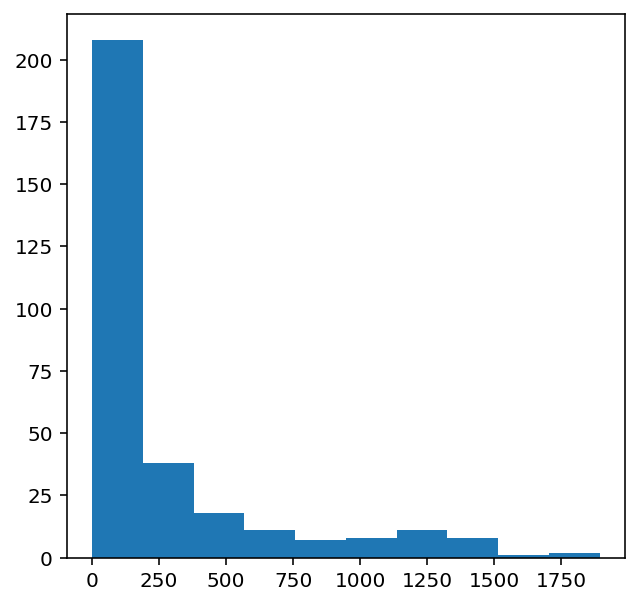

In [6]:
from collections import Counter
import matplotlib.pyplot as plt

# computing frequency of each note
freq = dict(Counter(notes_))

# consider only the frequencies
no = [count for _, count in freq.items()]

plt.figure(figsize=(5,5))
plt.hist(no)

In [7]:
# filter out the notes that have a frequency lower than 50
frequent_notes = [note_ for note_, count in freq.items() if count >= 50]
print(len(frequent_notes))

176


In [8]:
# filter out the notes with low frequency from the original data
new_music = []

for notes in notes_array:
    temp = []
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)
    new_music.append(temp)
    
new_music = np.array(new_music)

<ipython-input-8-0260187a6469>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_music = np.array(new_music)


In [9]:
# prepare data for training
# number of time steps
no_timesteps = 32

X = []
Y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_timesteps, 1):
        # preparing the input and outout sequence
        input_ = note_[i: i + no_timesteps]
        output_ = note_[i + no_timesteps]
        
        X.append(input_)
        Y.append(output_)

X = np.array(X)
Y = np.array(Y)

In [10]:
print(X.shape)
print(Y.shape)

(76373, 32)
(76373,)


In [11]:
# assign unique integer to every note
unique_X = list(set(X.ravel()))
X_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_X))

unique_Y = list(set(Y))
Y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_Y))

In [12]:
# prepare the input sequence
X_seq = []
for i in X:
    temp = []
    for j in i:
        # convert notes to unique integers
        temp.append(X_note_to_int[j])
    X_seq.append(temp)

X_seq = np.array(X_seq)

In [13]:
# prepare the output note
Y_seq = np.array([Y_note_to_int[i] for i in Y])

In [14]:
# train test split 80/20
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_seq, Y_seq, test_size=0.2, random_state=0)

In [15]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(61098, 32)
(61098,)
(15275, 32)
(15275,)


In [16]:
def lstm():
    """ LSTM model """
    model = Sequential()
    model.add(LSTM(128,return_sequences=True))
    model.add(LSTM(128))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    return model

In [17]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K

K.clear_session()

model = Sequential()

# embedding layber
model.add(Embedding(len(unique_X), 100, input_length = no_timesteps, trainable=True))

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_Y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           17600     
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 64)            19264     
_________________________________________________________________
dropout (Dropout)            (None, 32, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 128)           24704     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 128)            0

In [18]:
checkpoint_cb = ModelCheckpoint(
    "wavenet_weights.hdf5", 
    monitor='val_loss', 
    mode='min',
    save_best_only=True,
    verbose=1
    )

history = model.fit(X_train,
                    Y_train,
                    batch_size=128,
                    epochs=50,
                    validation_data=(X_val, Y_val),
                    verbose=1,
                    callbacks=[checkpoint_cb]
                   )

Epoch 1/50


UnknownError: 2 root error(s) found.
  (0) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv1d/conv1d (defined at <ipython-input-18-ccd79b885d05>:9) ]]
  (1) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv1d/conv1d (defined at <ipython-input-18-ccd79b885d05>:9) ]]
	 [[gradient_tape/sequential/embedding/embedding_lookup/Reshape/_34]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_1348]

Function call stack:
train_function -> train_function


In [ ]:
# load the trained model
model = tf.keras.models.load_model('wavenet_weights.hdf5')

In [ ]:
import random
ind = np.random.randint(0,len(X_val)-1)

random_music = X_val[ind]

predictions=[]
for i in range(100):

    random_music = random_music.reshape(1,no_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

In [ ]:
# convert prediction to notes
X_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_X)) 
predicted_notes = [X_int_to_note[i] for i in predictions]

In [ ]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='wavenet_music.mid')

In [ ]:
convert_to_midi(predicted_notes)